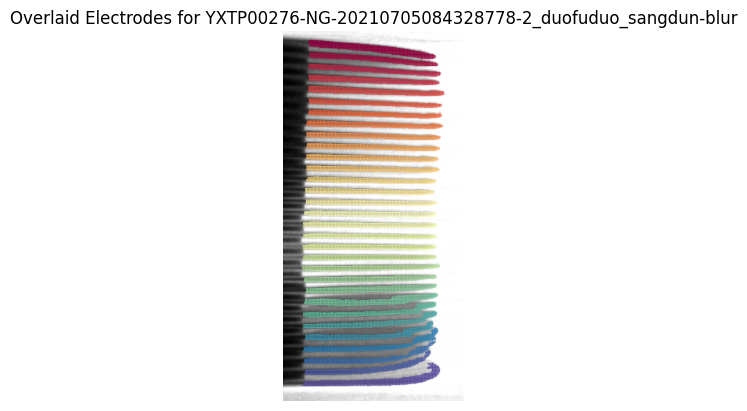

In [7]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

images_dir = "images"
masks_dir = "masks"
results_dir = "results"

# 1. Select a random .npy file from results
npy_files = [f for f in os.listdir(results_dir) if f.endswith('.npy')]
if not npy_files:
    raise ValueError("No .npy files found in the results folder.")

selected_npy = random.choice(npy_files)
base_name = os.path.splitext(selected_npy)[0]

# 2. Find the corresponding image in images_dir (any extension)
possible_image_extensions = ['.bmp', '.jpg', '.png', '.tif']
image_path = None
for ext in possible_image_extensions:
    candidate_img = os.path.join(images_dir, base_name + ext)
    if os.path.exists(candidate_img):
        image_path = candidate_img
        break

if image_path is None:
    raise FileNotFoundError(f"No corresponding image found for {base_name} with tried extensions: {possible_image_extensions}")

# 3. Find the corresponding crop mask in masks_dir (any extension)
mask_files = os.listdir(masks_dir)
crop_mask_path = None
# Find a file with the same base_name in masks
for m in mask_files:
    if os.path.splitext(m)[0] == base_name:
        crop_mask_path = os.path.join(masks_dir, m)
        break

if crop_mask_path is None:
    raise FileNotFoundError(f"No corresponding crop mask found for {base_name} in {masks_dir}")

# 4. Load the crop mask and determine cropping coordinates
crop_mask_img = Image.open(crop_mask_path).convert('L')
crop_mask = np.array(crop_mask_img) > 0
coords = np.where(crop_mask)
top = coords[0].min()
bottom = coords[0].max()
left = coords[1].min()
right = coords[1].max()

# 5. Load the original full-size image
full_img = Image.open(image_path).convert('L')
full_img_array = np.array(full_img)

# Apply the crop
img_cropped = full_img_array[top:bottom+1, left:right+1]

# 6. Load the stacked electrode masks
stacked_masks = np.load(os.path.join(results_dir, selected_npy))  # shape: (N, H, W)

# Check dimensions match
if stacked_masks.shape[1:] != img_cropped.shape:
    raise ValueError("Cropped image and electrode masks dimensions do not match.")

# 7. Overlay the electrode positions on the cropped image
fig, ax = plt.subplots()
ax.imshow(img_cropped, cmap='gray')

colors = plt.cm.Spectral(np.linspace(0, 1, stacked_masks.shape[0]))

for i in range(stacked_masks.shape[0]):
    mask = stacked_masks[i]
    Y, X = np.where(mask == 1)
    ax.plot(X, Y, 'o', markerfacecolor=colors[i], markeredgecolor='none', markersize=1, alpha=0.2)

ax.axis('off')
ax.set_title(f"Overlaid Electrodes for {base_name}")
plt.show()
